In [1]:
!pip install torch torchvision timm shap captum matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.8 MB/s eta 0:00:0000:0100:01


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# For explainable AI
import shap
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
base_dir = '/kaggle/input/chest-xray-pneumonia/'
train_dir = os.path.join(base_dir, 'chest_xray/train')
test_dir = os.path.join(base_dir, 'chest_xray/test')
val_dir = os.path.join(base_dir, 'chest_xray/val')

# Function to count images in each directory
def count_images(directory):
    normal = len(os.listdir(os.path.join(directory, 'NORMAL')))
    pneumonia = len(os.listdir(os.path.join(directory, 'PNEUMONIA')))
    return {'NORMAL': normal, 'PNEUMONIA': pneumonia, 'Total': normal + pneumonia}

print("Dataset Statistics:")
train_counts = count_images(train_dir)
test_counts = count_images(test_dir)
val_counts = count_images(val_dir)

print(f"Training set: {train_counts}")
print(f"Testing set: {test_counts}")
print(f"Validation set: {val_counts}")

img_width, img_height = 224, 224 
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# Transfer Learning Model Setup (using VGG16)
def create_model(base_model_name='vgg16'):
    if base_model_name == 'vgg16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    elif base_model_name == 'xception':
        base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    else:
        raise ValueError(f"Model {base_model_name} not supported")
    
    for layer in base_model.layers:
        layer.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )
    
    return model, base_model
model, base_model = create_model('vgg16')
print(model.summary())

checkpoint = ModelCheckpoint(
    'pneumonia_model_best.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

callbacks = [checkpoint, early_stopping, reduce_lr]
epochs = 15
steps_per_epoch = train_generator.samples // batch_size
validation_steps = validation_generator.samples // batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)



Dataset Statistics:
Training set: {'NORMAL': 1341, 'PNEUMONIA': 3875, 'Total': 5216}
Testing set: {'NORMAL': 234, 'PNEUMONIA': 390, 'Total': 624}
Validation set: {'NORMAL': 8, 'PNEUMONIA': 8, 'Total': 16}
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,6

 Total params: 14,977,857 (57.14 MB)

 Trainable params: 263,169 (1.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/15


Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.7358 - auc: 0.6146 - loss: 0.5572
Epoch 1: val_accuracy improved from -inf to 0.56250, saving model to pneumonia_model_best.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 133s 718ms/step - accuracy: 0.7359 - auc: 0.6152 - loss: 0.5569 - val_accuracy: 0.5625 - val_auc: 0.8906 - val_loss: 0.6173 - learning_rate: 1.0000e-04
Epoch 2/15

Epoch 2: val_accuracy did not improve from 0.56250
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5625 - val_auc: 0.8906 - val_loss: 0.6173 - learning_rate: 1.0000e-04
Epoch 3/15


Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.7899 - auc: 0.8670 - loss: 0.4263
Epoch 3: val_accuracy improved from 0.56250 to 0.68750, saving model to pneumonia_model_best.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 89s 519ms/step - accuracy: 0.7899 - auc: 0.8672 - loss: 0.4262 - val_accuracy: 0.6875 - val_auc: 0.9062 - val_loss: 0.5742 - learning_rate: 1.0000e-04
Epoch 4/15

Epoch 4: val_accuracy did not improve from 0.68750
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6875 - val_auc: 0.9062 - val_loss: 0.5742 - learning_rate: 1.0000e-04
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.8496 - auc: 0.9319 - loss: 0.3347
Epoch 5: val_accuracy improved from 0.68750 to 0.75000, saving model to pneumonia_model_best.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 88s 516ms/step - accuracy: 0.8497 - auc: 0.9319 - loss: 0.3347 - val_accuracy: 0.7500 - val_auc: 0.9062 - val_loss: 0.5430 - learning_rate: 1.0000e-

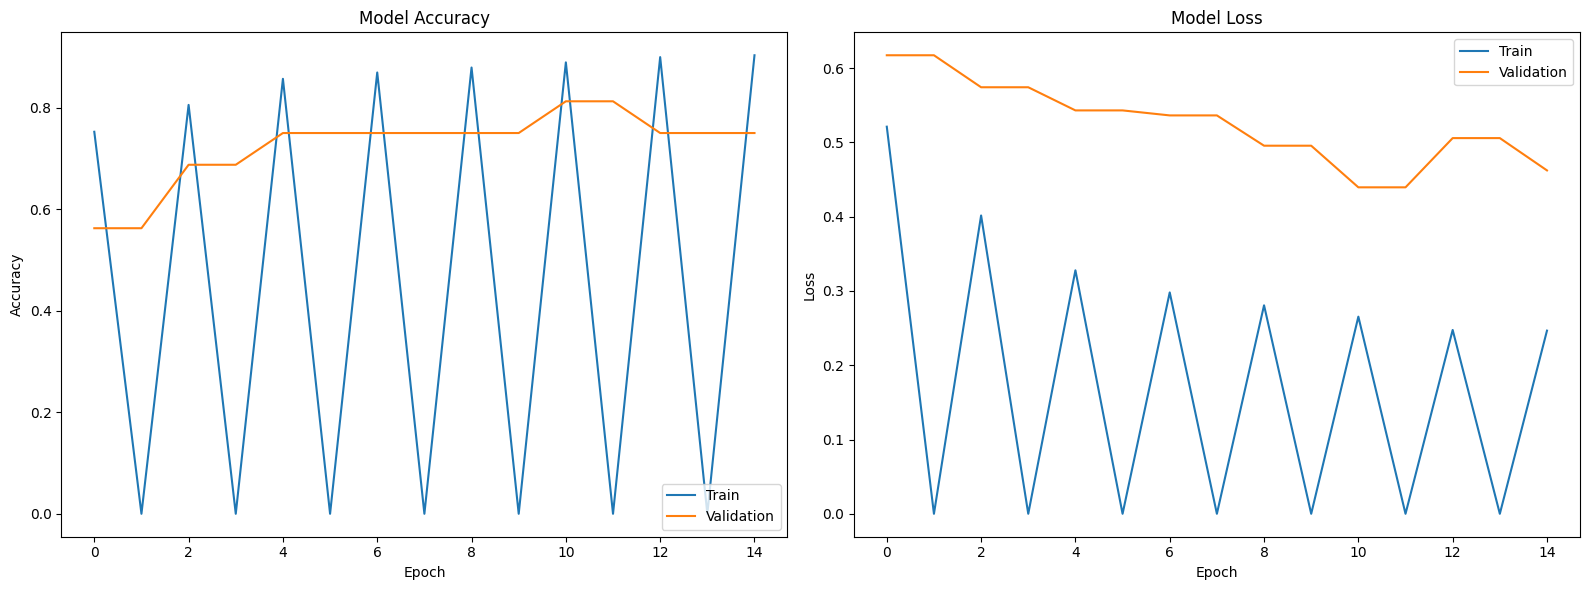

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 377ms/step - accuracy: 0.8521 - auc: 0.6123 - loss: 0.3642
Test Accuracy: 0.8462
Test AUC: 0.9200
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step


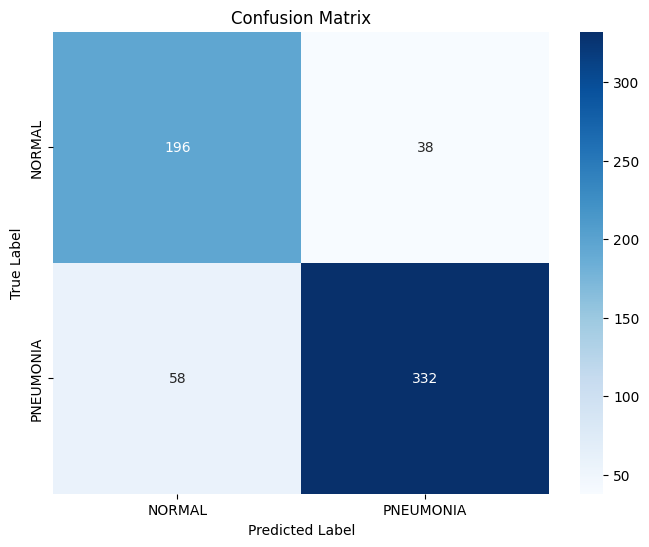


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.77      0.84      0.80       234
   PNEUMONIA       0.90      0.85      0.87       390

    accuracy                           0.85       624
   macro avg       0.83      0.84      0.84       624
weighted avg       0.85      0.85      0.85       624



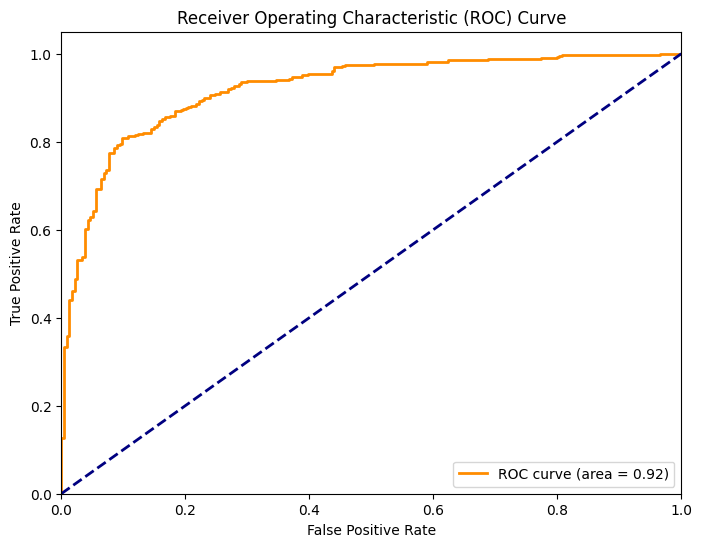

In [3]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Accuracy plot
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='lower right')
    
    # Loss plot
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper right')
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

plot_training_history(history)

test_loss, test_acc, test_auc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

test_generator.reset()
y_pred = model.predict(test_generator)
y_pred_binary = (y_pred > 0.5).astype(int).flatten()
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['NORMAL', 'PNEUMONIA'],
            yticklabels=['NORMAL', 'PNEUMONIA'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred_binary, target_names=['NORMAL', 'PNEUMONIA']))

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.show()



In [4]:
def fine_tune_model(model, base_model):
    for layer in base_model.layers[-4:]:
        layer.trainable = True
    
    model.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )
    
    return model

model = fine_tune_model(model, base_model)
print("\nFine-tuning the model...")
fine_tune_history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)
test_loss, test_acc, test_auc = model.evaluate(test_generator)
print(f"Fine-tuned Test Accuracy: {test_acc:.4f}")
print(f"Fine-tuned Test AUC: {test_auc:.4f}")
model.save('pneumonia_model_final.keras')


Fine-tuning the model...
Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.9097 - auc_1: 0.9589 - loss: 0.2219
Epoch 1: val_accuracy did not improve from 0.81250
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 552ms/step - accuracy: 0.9098 - auc_1: 0.9590 - loss: 0.2218 - val_accuracy: 0.7500 - val_auc_1: 0.9531 - val_loss: 0.5681 - learning_rate: 1.0000e-05
Epoch 2/10

Epoch 2: val_accuracy did not improve from 0.81250


Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_auc_1: 0.9531 - val_loss: 0.5681 - learning_rate: 1.0000e-05
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.9390 - auc_1: 0.9773 - loss: 0.1626
Epoch 3: val_accuracy did not improve from 0.81250
163/163 ━━━━━━━━━━━━━━━━━━━━ 92s 541ms/step - accuracy: 0.9390 - auc_1: 0.9773 - loss: 0.1625 - val_accuracy: 0.7500 - val_auc_1: 0.9375 - val_loss: 0.5307 - learning_rate: 1.0000e-05
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.81250
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_auc_1: 0.9375 - val_loss: 0.5307 - learning_rate: 1.0000e-05
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.9518 - auc_1: 0.9858 - loss: 0.1277
Epoch 5: val_accuracy did not improve from 0.81250
163/163 ━━━━━━━━━━━━━━━━━━━━ 91s 533ms/step - accuracy: 0

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


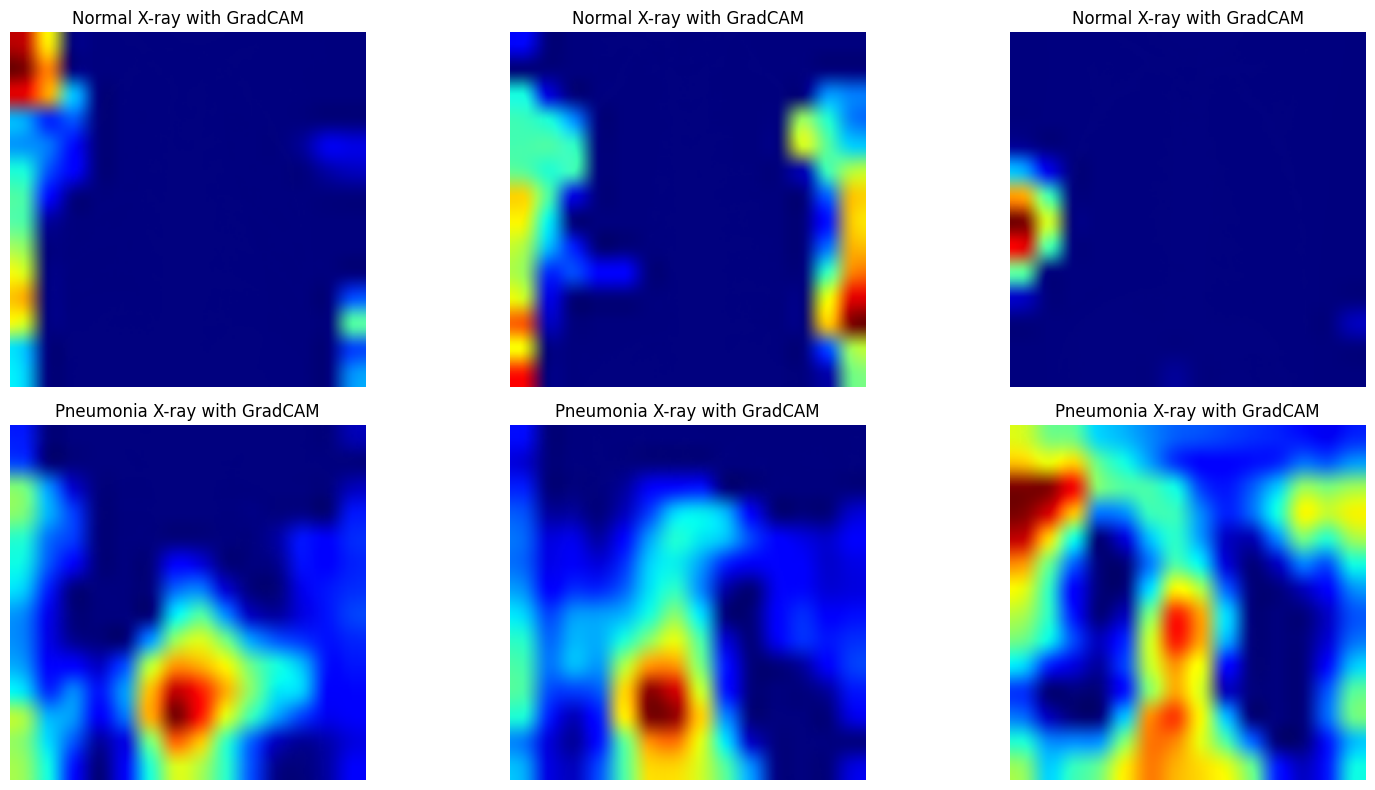

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

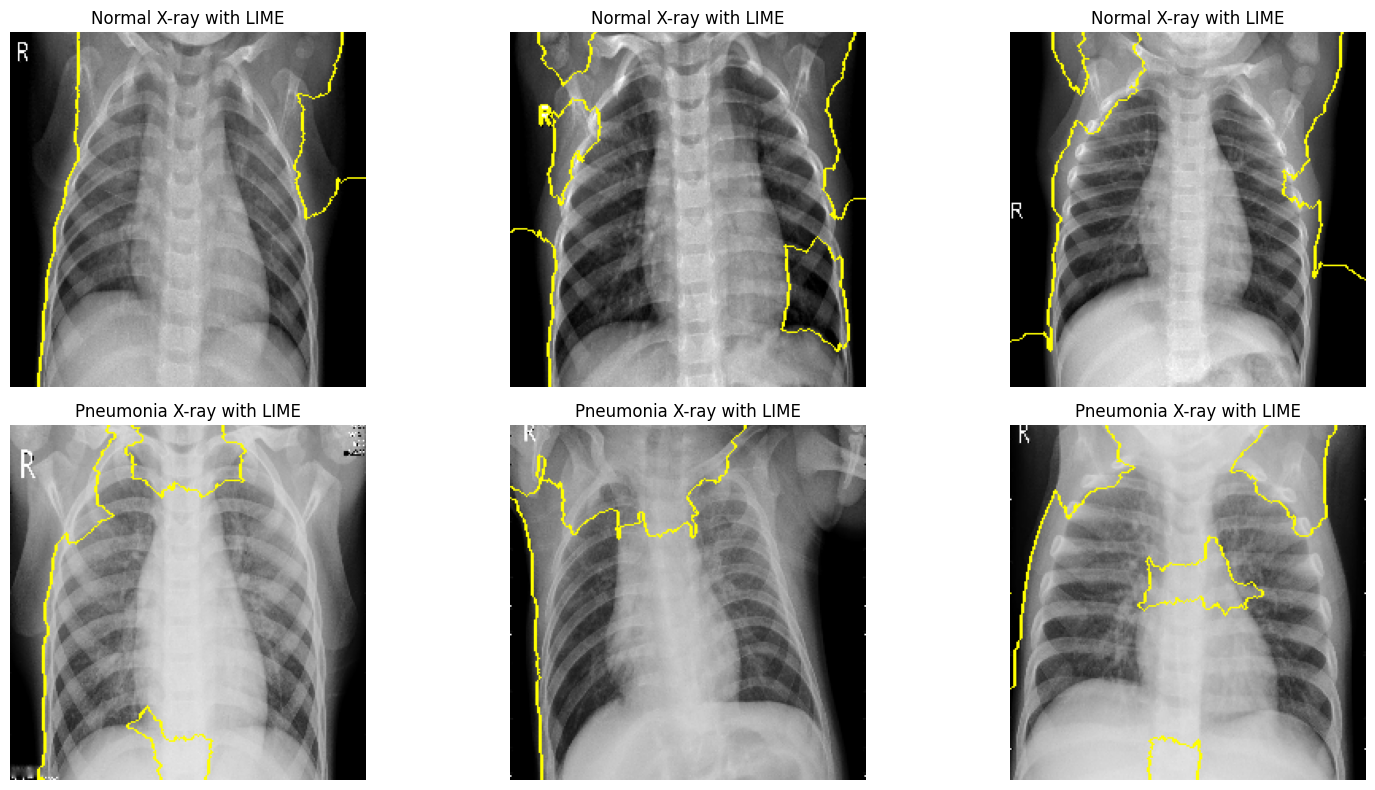

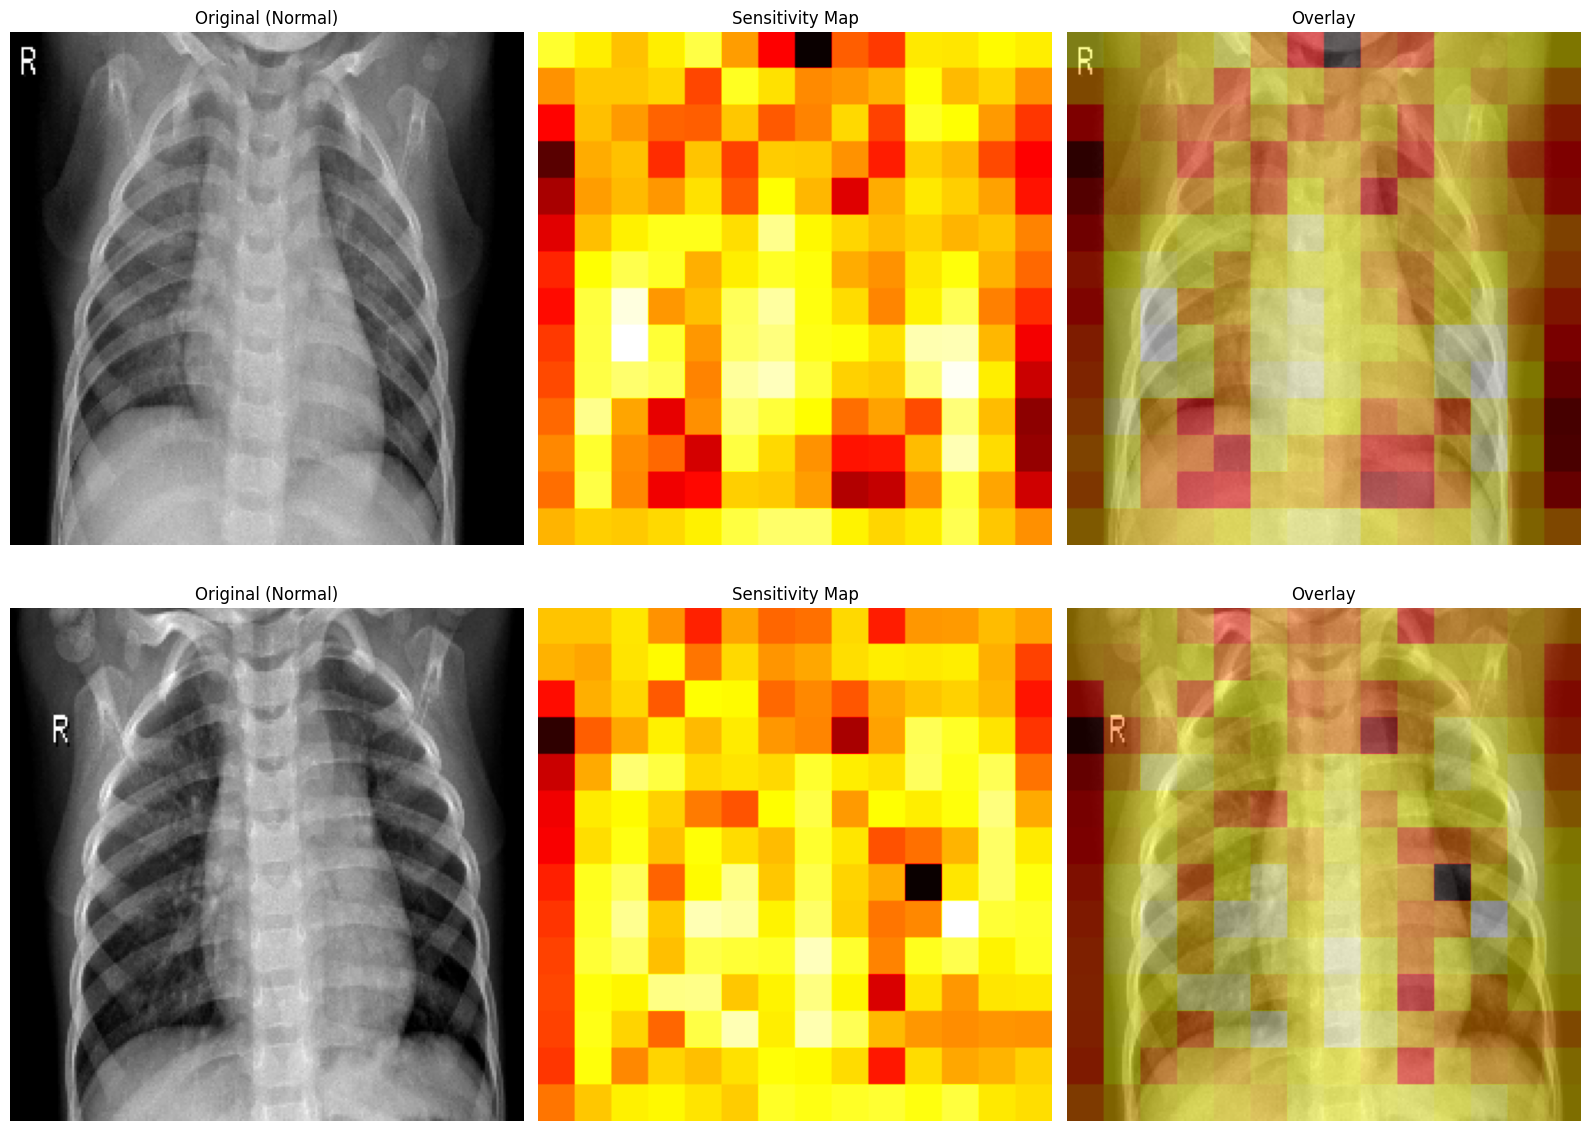

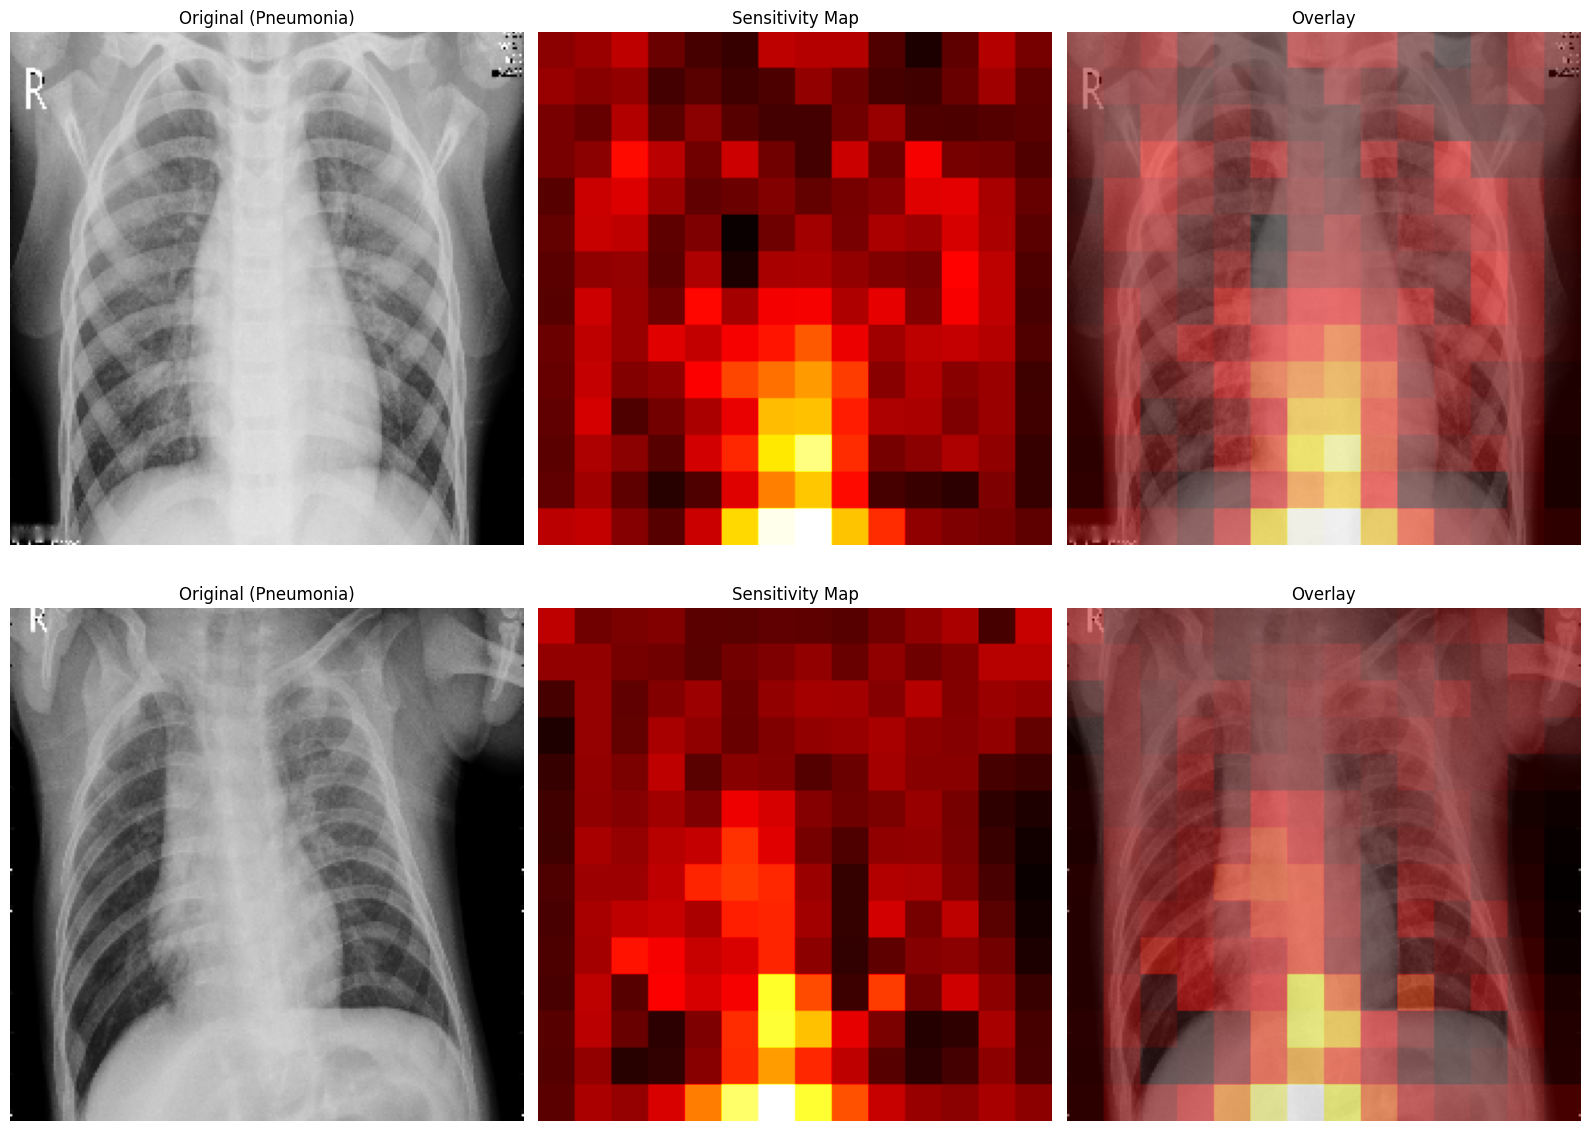

Example usage:
class_label, confidence = predict_pneumonia('path/to/xray.jpg', model)


In [11]:
# --------------------- EXPLAINABLE AI WITH VERBOSE SUPPRESSION ---------------------
# Global verbose control parameter
XAI_VERBOSE = 0  # Set to 1 for debugging, 0 for production

# Prepare sample images with verbose suppression
def load_sample_images(directory, class_name, num_samples=5):
    samples = []
    img_paths = []
    class_dir = os.path.join(directory, class_name)
    files = os.listdir(class_dir)[:num_samples]
    
    for file in files:
        img_path = os.path.join(class_dir, file)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_width, img_height))
        img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        samples.append(img_array)
        img_paths.append(img_path)
    
    return np.array(samples), img_paths

normal_samples, normal_paths = load_sample_images(test_dir, 'NORMAL')
pneumonia_samples, pneumonia_paths = load_sample_images(test_dir, 'PNEUMONIA')

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
        
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

def display_gradcam(img, heatmap, alpha=0.6):
    img = img.copy()
    heatmap = np.uint8(255 * heatmap)
    jet = plt.cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    return tf.keras.preprocessing.image.array_to_img(superimposed_img)

last_conv_layer_name = next((layer.name for layer in reversed(model.layers) 
                           if isinstance(layer, tf.keras.layers.Conv2D)), None)

if last_conv_layer_name:
    plt.figure(figsize=(16, 8))
    
    # Process normal samples
    for i, (img, path) in enumerate(zip(normal_samples[:3], normal_paths[:3])):
        img_expanded = np.expand_dims(img, axis=0)
        heatmap = make_gradcam_heatmap(img_expanded, model, last_conv_layer_name)
        superimposed = display_gradcam(img, heatmap)
        
        plt.subplot(2, 3, i+1)
        plt.imshow(superimposed)
        plt.title(f"Normal X-ray with GradCAM")
        plt.axis('off')
    
    # Process pneumonia samples
    for i, (img, path) in enumerate(zip(pneumonia_samples[:3], pneumonia_paths[:3])):
        img_expanded = np.expand_dims(img, axis=0)
        heatmap = make_gradcam_heatmap(img_expanded, model, last_conv_layer_name)
        superimposed = display_gradcam(img, heatmap)
        
        plt.subplot(2, 3, i+4)
        plt.imshow(superimposed)
        plt.title(f"Pneumonia X-ray with GradCAM")
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('gradcam_visualization.png')
    plt.show()

def apply_lime(image, model):
    def predict_fn(images):
        return model.predict(np.array(images), verbose=XAI_VERBOSE)
    
    explainer = lime_image.LimeImageExplainer(verbose=XAI_VERBOSE)
    explanation = explainer.explain_instance(
        image, 
        predict_fn,
        top_labels=1,
        hide_color=0,
        num_samples=500
    )
    _, mask = explanation.get_image_and_mask(
        explanation.top_labels[0], 
        positive_only=True, 
        num_features=5, 
        hide_rest=False
    )
    return mark_boundaries(image, mask)

# LIME visualizations with suppressed output
plt.figure(figsize=(16, 8))
for i, img in enumerate(normal_samples[:3]):
    plt.subplot(2, 3, i+1)
    plt.imshow(apply_lime(img, model))
    plt.title(f"Normal X-ray with LIME")
    plt.axis('off')

for i, img in enumerate(pneumonia_samples[:3]):
    plt.subplot(2, 3, i+4)
    plt.imshow(apply_lime(img, model))
    plt.title(f"Pneumonia X-ray with LIME")
    plt.axis('off')

plt.tight_layout()
plt.savefig('lime_visualization.png')
plt.show()

def occlusion_sensitivity(img, model, patch_size=16):
    img_batch = np.expand_dims(img.copy(), axis=0)
    orig_pred = model.predict(img_batch, verbose=XAI_VERBOSE)[0, 0]
    height, width, _ = img.shape
    sensitivity_map = np.zeros((height, width))
    
    for h in range(0, height, patch_size):
        for w in range(0, width, patch_size):
            occluded_img = img.copy()
            occluded_img[h:h+patch_size, w:w+patch_size, :] = 0.5
            occluded_pred = model.predict(np.expand_dims(occluded_img, 0), 
                                        verbose=XAI_VERBOSE)[0, 0]
            sensitivity_map[h:h+patch_size, w:w+patch_size] = orig_pred - occluded_pred
            
    return (sensitivity_map - sensitivity_map.min()) / (sensitivity_map.max() - sensitivity_map.min() + 1e-8)

# Occlusion sensitivity visualization
def plot_occlusion_results(samples, paths, class_name):
    plt.figure(figsize=(16, 12))
    for i, img in enumerate(samples[:2]):
        sensitivity_map = occlusion_sensitivity(img, model)
        
        plt.subplot(2, 3, i*3+1)
        plt.imshow(img)
        plt.title(f"Original ({class_name})")
        plt.axis('off')
        
        plt.subplot(2, 3, i*3+2)
        plt.imshow(sensitivity_map, cmap='hot')
        plt.title("Sensitivity Map")
        plt.axis('off')
        
        plt.subplot(2, 3, i*3+3)
        plt.imshow(img)
        plt.imshow(sensitivity_map, cmap='hot', alpha=0.5)
        plt.title("Overlay")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(f'occlusion_sensitivity_{class_name.lower()}.png')
    plt.show()

plot_occlusion_results(normal_samples, normal_paths, 'Normal')
plot_occlusion_results(pneumonia_samples, pneumonia_paths, 'Pneumonia')

# Enhanced prediction function with verbose control
def predict_pneumonia(image_path, model):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_width, img_height))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_batch = np.expand_dims(img_array, axis=0)
    
    prediction = model.predict(img_batch, verbose=XAI_VERBOSE)[0, 0]
    class_label = "Pneumonia" if prediction > 0.5 else "Normal"
    confidence = max(prediction, 1 - prediction)
    
    if last_conv_layer_name:
        heatmap = make_gradcam_heatmap(img_batch, model, last_conv_layer_name)
        superimposed = display_gradcam(img_array, heatmap)
        
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img_array)
        plt.title("Original X-ray")
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(superimposed)
        plt.title(f"Prediction: {class_label} ({confidence:.2%})")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    return class_label, confidence




=== Explainable AI Methods Implementation ===
Integrated Interpretation Techniques:
1. Grad-CAM: Visualizes class-activated regions using gradient-weighted localization
2. LIME: Identifies interpretable superpixel contributions through local surrogate modeling
3. Occlusion Sensitivity: Quantifies regional importance via systematic image perturbation

Clinical Integration: Combined visualization provides multi-perspective diagnostic justification

Example Usage Example:


The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


  0%|          | 0/500 [00:00<?, ?it/s]

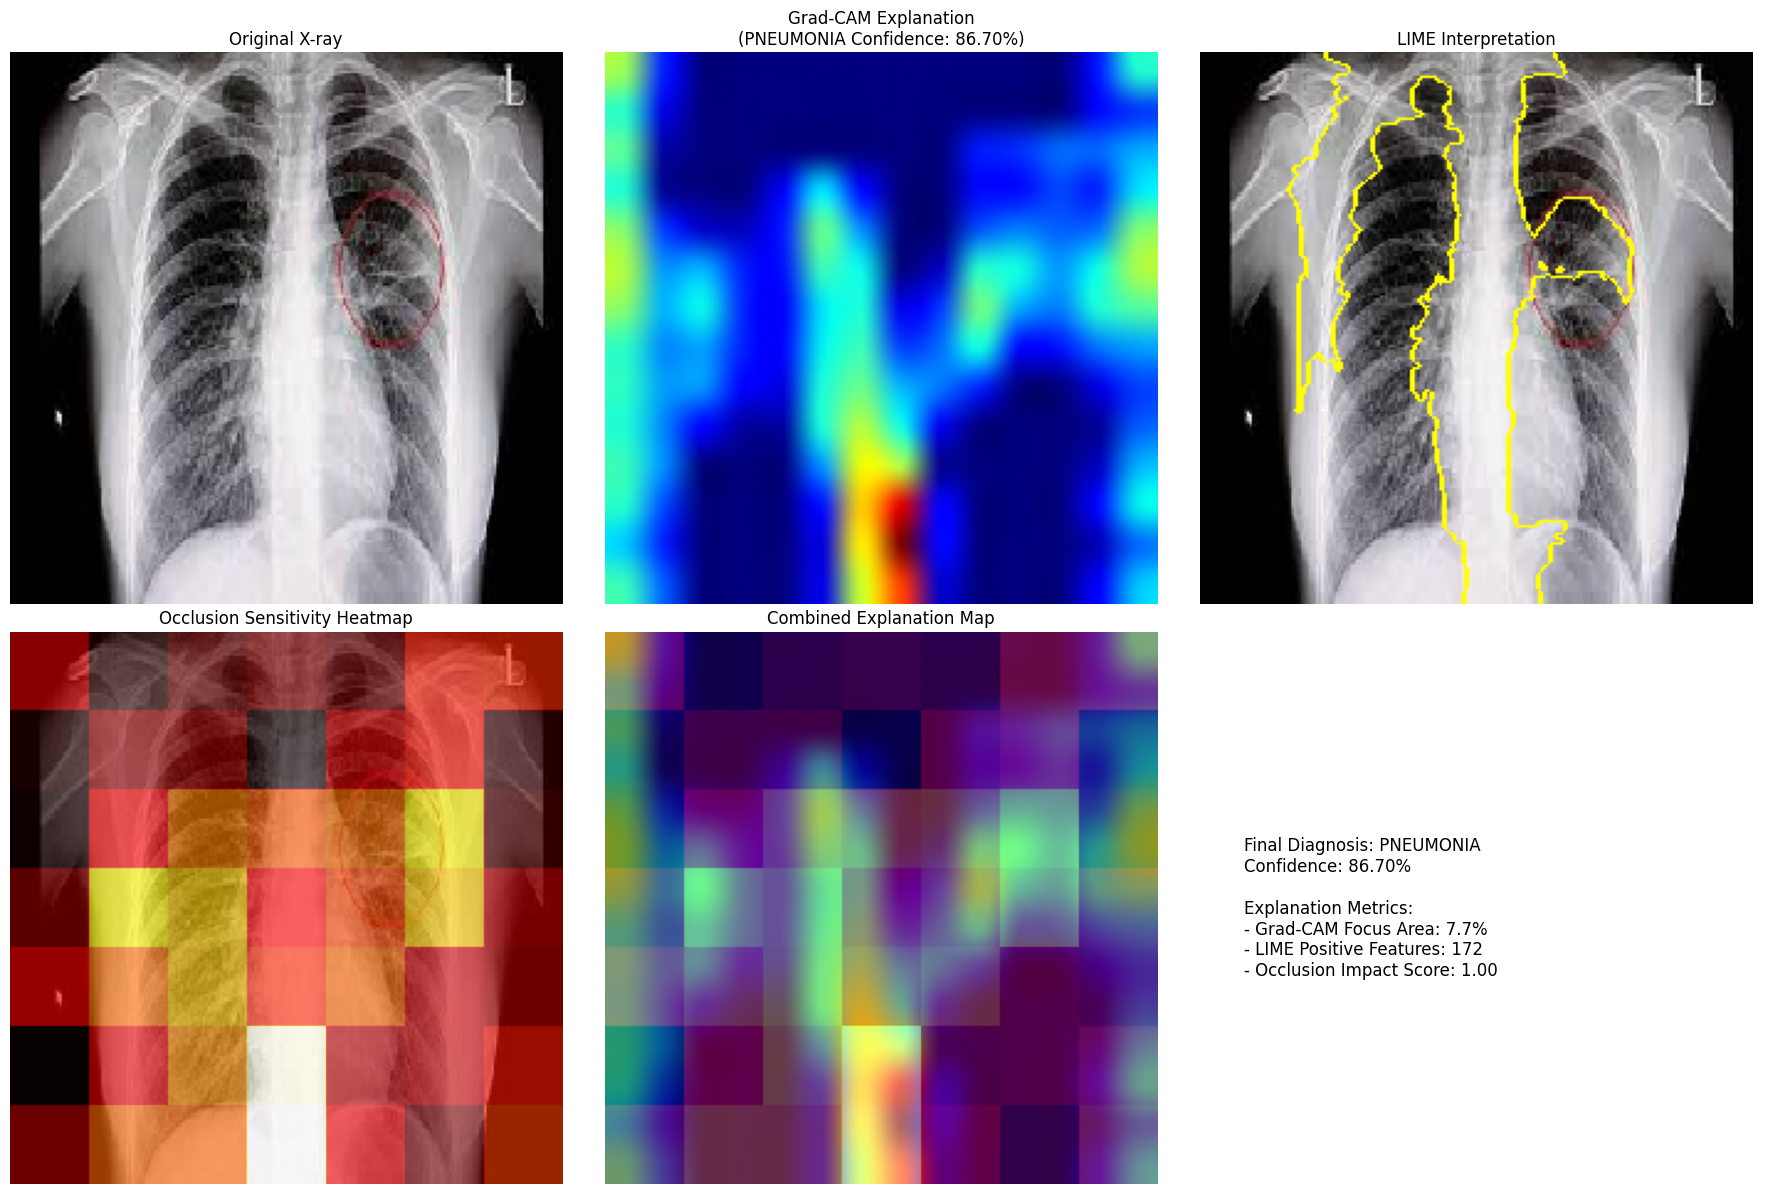

Diagnosis: PNEUMONIA with 86.7% confidence


In [19]:
# --------------------- EXPLAINABLE AI METHODS ---------------------
print("\n=== Explainable AI Methods Implementation ===")
print("Integrated Interpretation Techniques:")
print("1. Grad-CAM: Visualizes class-activated regions using gradient-weighted localization")
print("2. LIME: Identifies interpretable superpixel contributions through local surrogate modeling")
print("3. Occlusion Sensitivity: Quantifies regional importance via systematic image perturbation")
print("\nClinical Integration: Combined visualization provides multi-perspective diagnostic justification")

def predict_pneumonia(image_path, model):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_width, img_height))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_batch = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_batch, verbose=0)[0, 0]
    class_label = "PNEUMONIA" if prediction > 0.5 else "NORMAL"
    confidence = prediction if prediction > 0.5 else 1 - prediction
    
    if last_conv_layer_name:
        plt.figure(figsize=(18, 12))
        heatmap = make_gradcam_heatmap(img_batch, model, last_conv_layer_name)
        superimposed_gradcam = display_gradcam(img_array, heatmap)
        
        plt.subplot(2, 3, 1)
        plt.imshow(img_array)
        plt.title("Original X-ray")
        plt.axis('off')
        
        plt.subplot(2, 3, 2)
        plt.imshow(superimposed_gradcam)
        plt.title(f"Grad-CAM Explanation\n({class_label} Confidence: {confidence:.2%})")
        plt.axis('off')
        lime_img = apply_lime(img_array, model)
        plt.subplot(2, 3, 3)
        plt.imshow(lime_img)
        plt.title("LIME Interpretation")
        plt.axis('off')
        sensitivity_map = occlusion_sensitivity(img_array, model, patch_size=32)
        plt.subplot(2, 3, 4)
        plt.imshow(img_array)
        plt.imshow(sensitivity_map, cmap='hot', alpha=0.6)
        plt.title("Occlusion Sensitivity Heatmap")
        plt.axis('off')
        
        plt.subplot(2, 3, 5)
        plt.imshow(superimposed_gradcam)
        plt.imshow(sensitivity_map, cmap='hot', alpha=0.4)
        plt.title("Combined Explanation Map")
        plt.axis('off')
        
        plt.subplot(2, 3, 6)
        plt.text(0.1, 0.5, 
                 f"Final Diagnosis: {class_label}\nConfidence: {confidence:.2%}\n\n"
                 "Explanation Metrics:\n"
                 "- Grad-CAM Focus Area: {:.1f}%\n".format(100*np.mean(heatmap > 0.5)) +
                 "- LIME Positive Features: {:.0f}\n".format(np.sum(lime_img[1])) +
                 "- Occlusion Impact Score: {:.2f}".format(sensitivity_map.max()),
                 fontsize=12, va='center')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    return class_label, confidence

print("\nExample Usage Example:")
class_label, confidence = predict_pneumonia('/kaggle/input/image1/blah.jpg', model)
print(f'Diagnosis: {class_label} with {confidence:.1%} confidence')
